# Dogs vs Cats Redux


This is fastai lesson 1 homework: submit dogs-vs-cats problems on Kaggle.
First approach was to build a python CLI that allows to train, sample models and generate predictions.
Second approach is to create a ipython notebook (to store the thinking process). Notebook will use utils from the python CLI.

__Plan__:
1. setup env (directory paths)
2. download competition files
3. rearrange the data (train, valid, test, sample dirs)
4. finetune and train the model
5. verify the model (manually examine validation results)
6. generate predictions
7. submit predictions to Kaggle


## Setup env

In [3]:
#Verify we are in the lesson1 directory
%pwd

u'/home/tollek/workspace/personal/fastai/fastai-tollek/homework'

In [4]:
import os,sys
WORKING_DIR = os.getcwd()
DATA_DIR = WORKING_DIR + "/../data/dogs-vs-cats-redux-kernels-edition"

In [9]:
lib_path = os.path.abspath('../fastai-course/deeplearning1/nbs/')
print lib_path
sys.path.append(lib_path)

#import modules
from utils import *
from vgg16 import Vgg16

import numpy as np
np.set_printoptions(precision=4, linewidth=100)

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

/home/tollek/workspace/personal/fastai/data/fastai-course/deeplearning1/nbs


## Download competition files


In [4]:
%cd $DATA_DIR

/home/tollek/workspace/personal/fastai/data/dogs-vs-cats-redux-kernels-edition


In [5]:
! kg download -c dogs-vs-cats-redux-kernels-edition

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip

test.zip already downloaded !
downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip

train.zip already downloaded !
downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/sample_submission.csv

sample_submission.csv already downloaded !


In [ ]:
! unzip -u -q test.zip
! unzip -u -q train.zip

## Rearrange the data

Desired file structure:
    
    homework/
        01_dogs_cats_redux.ipynb    
    data/
        train/
            cats/
            dogs/
        valid/
            cats/
            dogs/
        test/
            unknown/
        sample200_50/           # 100 training files per class + 25 training files per class
            train/
                cats/
                dogs/
            valid/
                cats/
                dogs/
                

In [7]:
# First, move a number of validation samples
%mkdir valid
! find train -name "*.jpg" | shuf -n 2000 | xargs mv -t valid

# Next, create sample directory by copying files from train/ and valid/
%mkdir sample200_50
%mkdir sample200_50/train
%mkdir sample200_50/valid
! find train -name "*.jpg" | shuf -n 200 | xargs cp -t sample200_50/train
! find valid -name "*.jpg" | shuf -n 50 | xargs cp -t sample200_50/valid


In [8]:
# Rearrange the files in the directories
%mkdir train/cats
%mkdir train/dogs
%mv train/cat*.jpg train/cats
%mv train/dog*.jpg train/dogs

%mkdir valid/dogs
%mkdir valid/cats
%mv valid/cat*.jpg valid/cats
%mv valid/dog*.jpg valid/dogs

%mkdir sample200_50/train/cats
%mkdir sample200_50/train/dogs
%mv sample200_50/train/cat*.jpg sample200_50/train/cats
%mv sample200_50/train/dog*.jpg sample200_50/train/dogs

%mkdir sample200_50/valid/cats
%mkdir sample200_50/valid/dogs
%mv sample200_50/valid/cat*.jpg sample200_50/valid/cats
%mv sample200_50/valid/dog*.jpg sample200_50/valid/dogs

In [259]:
# Create single 'unknown' class for test set
%mkdir test/unknown
%mv test/*.jpg test/unknown/

## Finetune and train the model

In [6]:
%cd $DATA_DIR

#path = DATA_DIR + '/sample200_50'
path = DATA_DIR
test_path = DATA_DIR + '/test/' 
results_path=DATA_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

%mkdir $results_path

/home/tollek/workspace/personal/fastai/data/dogs-vs-cats-redux-kernels-edition
mkdir: cannot create directory ‘/home/tollek/workspace/personal/fastai/fastai-tollek/homework/../data/dogs-vs-cats-redux-kernels-edition/results/’: File exists


In [5]:
#import Vgg16 helper class
vgg = Vgg16()

In [6]:
batch_size = 8
epochs = 3


In [7]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [13]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % epochs

Running epoch: 0
Epoch 1/1
23000/23000 [==============================] - 4547s - loss: 0.5271 - acc: 0.9635 - val_loss: 0.2732 - val_acc: 0.9820
Running epoch: 1
Epoch 1/1
23000/23000 [==============================] - 4499s - loss: 0.4442 - acc: 0.9712 - val_loss: 0.1859 - val_acc: 0.9875
Running epoch: 2
Epoch 1/1
23000/23000 [==============================] - 4494s - loss: 0.4286 - acc: 0.9725 - val_loss: 0.2580 - val_acc: 0.9840
Completed 3 fit operations


## Verify the model

Plan:
1. show confusion matrix (dogs as dogs, dogs as cats, etc)
2. show best, most certian predictions (dogs as dogs, cats as cats)
4. show bad predictions (dogs as cats, cats as dogs)
5. show least certain predictions (closed to 0.5)

NOTE: on fastai notebook, they use model after first epoch for the validation. Models in further epochs will have more confidence in the scores, so checking where model is 'unsure' is impossible/harder.

In [255]:
# (optionally) garbage collection of the current vgg object/model
vgg = None
import gc
for i in range(3): gc.collect()

In [117]:
# (optionally) reload the model
batch_size = 4

vgg = Vgg16()
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size)
vgg.finetune(batches)
vgg.model.load_weights(results_path+"ft0.h5")

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [148]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

### Make the predictions.

In [118]:
test_batches, predictions = vgg.test(valid_path)
filenames = val_batches.filenames
expected_labels = val_batches.classes

Found 2000 images belonging to 2 classes.


In [157]:
# our_labels should be: 1 - dog, 0 - cat.
# We round the numbers to 0 decimal points (0/1)
our_predictions = predictions[:,0]
is_cat = predictions[:,0].round(0)
is_dog = 1 - is_cat
our_labels = is_dog

### Show confusion matrix

https://en.wikipedia.org/wiki/Confusion_matrix

Predictions matrix shows real class (cols) vs predicted class (rows)



[[978  32]
 [  4 986]]


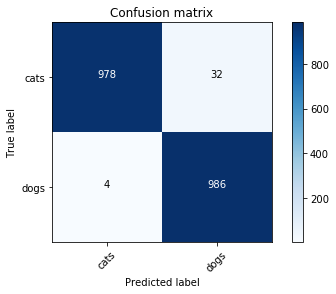

In [203]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

plot_confusion_matrix(cm, val_batches.class_indices, normalize=False)

### Correct dogs

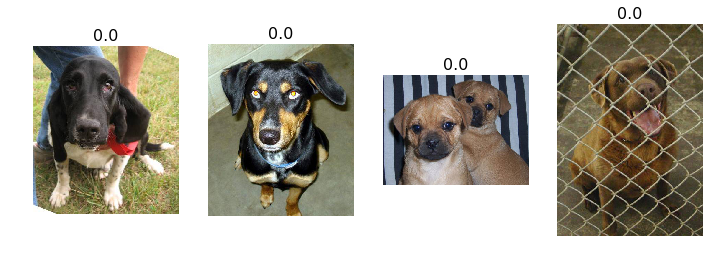

In [204]:
# this is a tuple...
correct_dogs = np.where((our_labels == 1) & (expected_labels == 1))[0]
idx = permutation(correct_dogs)[:n_view]
plots_idx(idx, our_predictions[idx])

### Correct cats

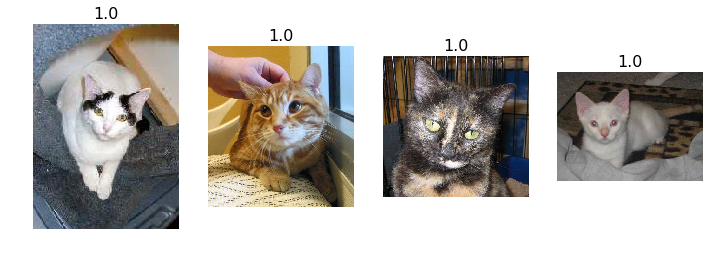

In [205]:
correct_cats = np.where((our_labels == 0) & (expected_labels == 0))[0]
idx = permutation(correct_cats)[:n_view]
plots_idx(idx, our_predictions[idx])

### Incorrect dogs

Found 32 incorrect dogs


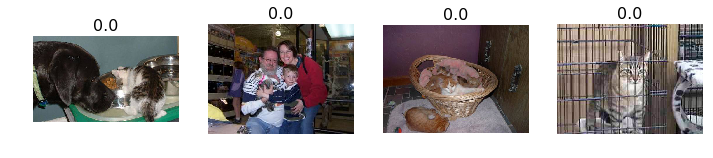

In [220]:
incorrect_dogs = np.where((our_labels == 1) & (expected_labels == 0))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], titles=our_predictions[incorrect_dogs][most_incorrect_dogs])

### Incorrect cats

Found 4 incorrect cats


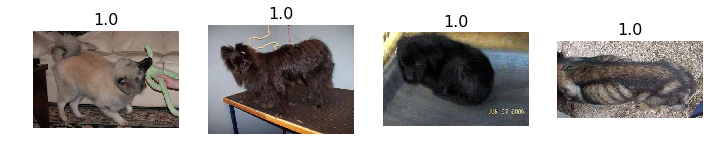

In [221]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    # ::-1 will reverse the array. We want the images of 'most confident cats' (our_predictions closest to 1.0)
    # argsort return indexes of elements to sort the array ascedning, we want descending.
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

### Most uncertain

[617 153 658 942]
[ 0.705   0.9519  0.0189  0.0145]


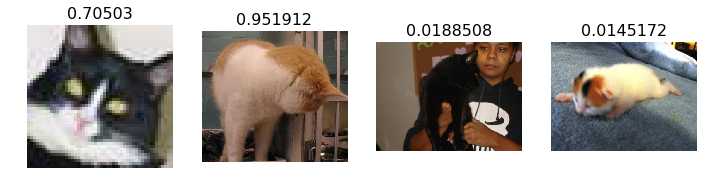

In [240]:
x = np.abs(our_predictions - 0.5)
most_uncertain = np.argsort(x)[:n_view]
print most_uncertain
print our_predictions[most_uncertain]
if len(most_uncertain):
    plots_idx(most_uncertain, our_predictions[most_uncertain])



## Generate predictions

In [15]:
# (optionally) garbage collection of the current vgg object/model
vgg = None
import gc
for i in range(3): gc.collect()

In [16]:
batch_size = 8

vgg = Vgg16()
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size)
vgg.finetune(batches)
vgg.model.load_weights(results_path+"ft2.h5")

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [17]:
test_batches, predictions = vgg.test(test_path, batch_size=batch_size)
filenames = test_batches.filenames

save_array(results_path+'predictions', predictions)
save_array(results_path+'filenames', filenames)

Found 12500 images belonging to 1 classes.


## Submit to Kaggle

Kaggle expects CSV file of format:
    
```
id,label
1,0.5
2,0.5
3,0.5
4,0.5
5,0.5
```

NOTE: it's expected to give probability instead of 0/1 label for each sample.


### Loss function
Kaggle uses log-loss function: it penalizes being over-confident on invalid samples (labelling dog as cat has large penalty).
    

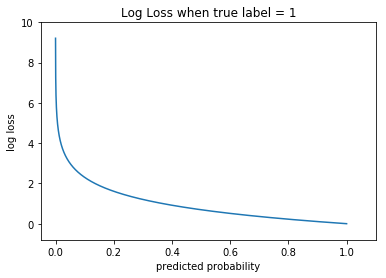

In [45]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1], [i*.0001], labels=[1,0]) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

Google spreadsheet that calculates optimal cut:
https://docs.google.com/spreadsheets/d/1UGa9QUd9FISeTdR0CAgtYQI3S3FhpcluMSbAakFrWdg/edit?usp=sharing

In [86]:
labels = 1 - predictions[:,0].round()
ids = [int(x[8:x.find('.')]) for x in filenames]

clip = 0.02 # calculated in spreadsheet & tested on Kaggle
labels_rounded = labels.clip(clip, 1-clip)

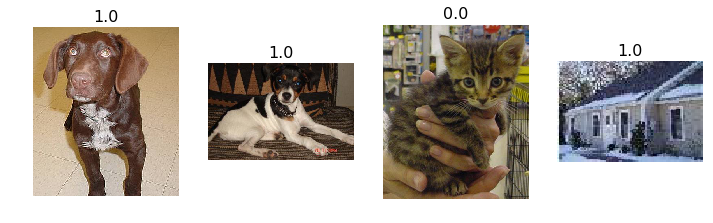

In [82]:
def plots_test_idx(idx, titles=None):
    plots([image.load_img(test_path + filenames[i]) for i in idx], titles=titles)
    
show = [0,1,2,3]    
plots_test_idx(show, titles=labels[show])    

In [87]:
csv_content = np.stack([ids, labels_rounded], axis=1)
csv_content[:5]

array([[  1.0765e+04,   9.8000e-01],
       [  4.2330e+03,   9.8000e-01],
       [  7.9900e+02,   2.0000e-02],
       [  4.7480e+03,   9.8000e-01],
       [  4.8220e+03,   9.8000e-01]])

In [88]:
%cd $DATA_DIR
submission_file_name = 'submission2.csv'
np.savetxt(submission_file_name, csv_content, fmt='%d,%.5f', header='id,label', comments='')

/home/tollek/workspace/personal/fastai/data/dogs-vs-cats-redux-kernels-edition
